# Graded Exercise 2: Anomaly Detection on Acoustic Data

- **Course**: [CIVIL-426 - Machine Learning for Predictive Maintenance](https://edu.epfl.ch/coursebook/en/machine-learning-for-predictive-maintenance-applications-CIVIL-426)
- **Start Date**: 2024.10.03 at 10:15
- **Due Date**: 2024.10.23 at 23:59
- **Student 0**:
    - Name: `FILL HERE`
    - SCIPER: `FILL HERE`
- **Student 1**:
    - Name: `FILL HERE`
    - SCIPER: `FILL HERE`

# Introduction
Anomalous sound detection (ASD) refers to the task of identifying whether the sounds emitted from a target machine are normal or anomalous.
In real-world industrial environments, anomalies are infrequent and can exhibit significant variability, making it impractical to build an exhaustive set of anomalous sound patterns.
As a result, our goal is to detect anomalous sounds using only normal sound clips for training.

This challenge cannot be approached as a simple classification problem (anomaly vs healthy). Instead, it is formulated as a **one-class classification** problem, where the model is trained on normal sound data to detect deviations from the learned pattern.

Anomalous sound detection can be achieved with following steps:
   - Feature Extraction (I)
   - One-class Classifier Training (II)
   - Decisions based on a threshold from your trained classifier (III)
   
Through this assignment, you will primarily focus on tasks (I) and (II).
The quality of your one-class classifier will be assessed using the **Area Under the Curve (AUC)** score on the test dataset.

The model used here is a type of neural network called **AutoEncoder** (AE). AE is trained to reconstruct the input data while compressing the input data into a lower-dimensional latent space and minimizing information loss during this process.
Thus, you will also modify the extracted features and Neural Network used in this notebook to improve the anomalous sound detection performance.

The dataset is composed of two different machines, a Pump and a Valve. For each machine you have:
- A **training dataset** composed of *only healthy* sound data
- A **test dataset** composed of *both healthy and abnormal* sound data

# Questions:

Your task is to improve the anomalous sound detection performance by modifying the feature extraction process and neural network architecture. You are expected to experiment with various feature representations and neural network configurations to optimize detection results.

Specifically, the following questions must be addressed. Each question should be discussed separately for both the Pump and Valve datasets. The answers are to be provided in a PDF report, and the full Jupyter notebook must also be submitted.

**Question 1:** Given the provided code, fill in the blank spaces to extract signal features, train a simple AutoEncoder that reconstructs the inputs MEL-Spectogram, and report the AUC score.

**Question 2:** From the trained AutoEncoder, use the bottleneck features to train both (1) a One-Class SVM and (2) an Isolation Forest, and report the corresponding AUC scores.

**Question 3:** Instead of using AutoEncoder features, apply PCA to project the MEL-spectrogram into a smaller dimensional space, then train (1) a One-Class SVM and (2) an Isolation Forest, and report the AUC scores.

**Question 4:** Determine an appropriate threshold for distinguishing anomalies based on the given results, and compute the following metrics: Accuracy, True Positive Rate (TPR), False Positive Rate (FPR), and F1-score.

**Question 5:** Visualize essential steps and provide a thorough discussion of the results obtained from all the methods.  

**Bonus Question:** Modify the AutoEncoder architecture to a 2D AutoEncoder using convolutional layers instead of fully connected layers, and analyze its performance.

## Download Dataset

In [654]:
%pip install gdown --upgrade --quiet
import gdown

Note: you may need to restart the kernel to use updated packages.


In [655]:
# Pump Dataset
gdown.download(id='1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn', output="./dev_data_pump_04.zip")

KeyboardInterrupt: 

In [3]:
# Valve Dataset
gdown.download(id='1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M', output="./dev_data_valve_00.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M
From (redirected): https://drive.google.com/uc?id=1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M&confirm=t&uuid=77493bd4-d49c-4dd3-8ce2-10c7cf611d74
To: /Users/sopheabonnne/EPFL/CIVIL-426/ml4pm/assignment_2/dev_data_valve_00.zip
100%|██████████| 269M/269M [00:17<00:00, 15.4MB/s] 


'./dev_data_valve_00.zip'

In case that above links do not work, you can also manully download the dataset here:
- **dev_data_pump_04.zip**: https://docs.google.com/uc?export=download&id=1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn
- **dev_data_valve_00,zip**: https://docs.google.com/uc?export=download&id=1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M

In [12]:
!unzip dev_data_pump_04.zip
!unzip dev_data_valve_00.zip

Archive:  dev_data_pump_04.zip
   creating: dev_data_pump_04/
   creating: dev_data_pump_04/pump/
   creating: dev_data_pump_04/pump/test/
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000000.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000001.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000002.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000003.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000004.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000005.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000006.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000007.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000008.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000009.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000010.wav  
  inflating: dev_data_pump_04/pump/test/anomaly_id_04_00000011.wav  
  inflating: dev_data_pump_04/pum

## Import Dependency

In [222]:
import os
import sys
import librosa
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns



## Audio Data Loading and MEL-Spectrogram Feature Extraction

The code is adapted from https://github.com/MIMII-hitachi/mimii_baseline

Copyright (C) 2019 Hitachi, Ltd. All right reserved.

Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, "MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection," arXiv preprint arXiv:1909.09347, 2019.

In [597]:
########################################################################
# import additional python-library
########################################################################
import librosa.core
import librosa.feature

# WAV File Input
def load_wav_files(wav_file_name, mono=True):
    """Load a .wav file."""
    try:
        return librosa.load(wav_file_name, sr=None, mono=mono)
    except Exception as e:
        print(f"Failed to load file '{wav_file_name}'. Error: {e}")
        raise

def demux_wav_files(wav_file_name, channel=0):
    """Demux a .wav file and return a specific channel."""
    try:
        multi_channel_data, sr = load_wav_files(wav_file_name, mono=False)
        if multi_channel_data.ndim == 1:
            return sr, multi_channel_data
        return sr, multi_channel_data[channel, :]
    except ValueError as e:
        print(f"Error in demuxing file '{wav_file_name}': {e}")
        raise

# Feel free to modify and analysis the images in your report
def plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram):
    plt.figure(1)
    n = len(y)
    t = np.linspace(tmin, tmax, n)
    plt.plot(t, y)
    plt.xlim(t[0],t[-1])
    plt.xlabel('time/s',fontsize=20)
    plt.ylabel('Amplitude',fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    
    plt.figure(2)
    freq = sr/n*np.linspace(0,n/2,int(n/2)+1)
    plt.plot(freq,np.absolute(np.fft.rfft(y[tmin*sr:tmax*sr],n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    
    plt.figure(3)
    plt.plot(freq,np.absolute(np.fft.rfft(emphasized_y,n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    
    plt.figure(4)
    librosa.display.specshow(log_mel_spectrogram)
    plt.colorbar()

########################################################################
# Feature Extractor
########################################################################
def file_to_features(file_name,
                     n_mels=64,
                     frames=1,
                     n_fft=1024,
                     hop_length=512,
                     power=2.0,
                     plot=True):
    """Convert a WAV file to a vector array."""
    # Step 01: Load the demuxed wav files
    sr, y = demux_wav_files(file_name, channel=0)
    
    # Step 02: Signal Pre-emphasis
    tmin = int(0)
    tmax = int(len(y)/sr)
    alpha = 0.95
    emphasized_y = np.append(y[0],
                             y[1:] - alpha*y[:-1])
    
    # Step 03: Generate MEL-Spectrogram
    # ===================================
    mel_spec = librosa.feature.melspectrogram(y=emphasized_y, 
                                              sr=sr, 
                                              n_fft=n_fft, 
                                              hop_length=hop_length, 
                                              n_mels = n_mels, 
                                              power = power)
    # ===================================

    # Step 04: Convert MEL-Spectrogram to log scale
    # ===================================
    log_mel_spectrogram = librosa.power_to_db(mel_spec, ref=np.max)
    # ===================================
    
    
    # Step 05: Define Feature Vector Array
    dims = n_mels * frames
    length = len(log_mel_spectrogram[0,:]) - frames + 1
    features = np.zeros((length, dims), float)
    
    # Pad short clips instead of skipping
    if length < 1:
        print(f"Audio file '{file_name}' is too short. Padding applied.")
        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, frames - 1)), mode='constant')
        length = 1
    
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + length].T
    
    if plot:
        plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram)
    return features

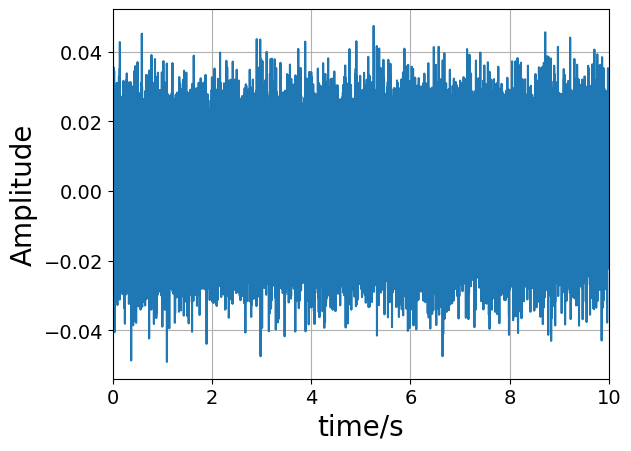

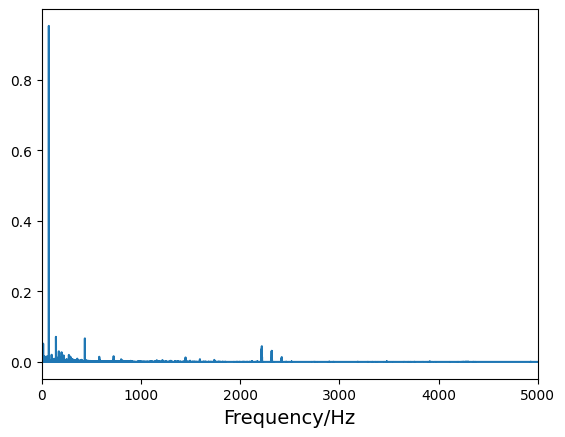

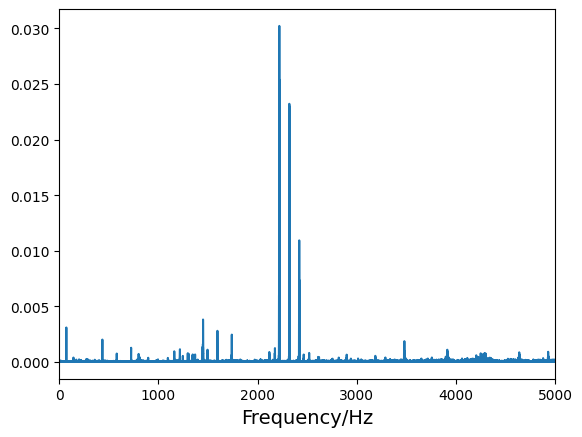

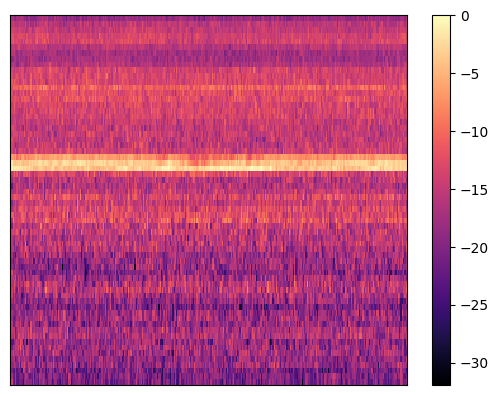

In [610]:
wav_test_file = 'dev_data_pump_04/pump/train/normal_id_04_00000000.wav'
# wav_test_file = 'dev_data_pump_04/pump/test/anomaly_id_04_00000000.wav'

# Visualize your results for potential analysis in your report
features = file_to_features(wav_test_file)

## PyTorch Dataset Splitting

To define and optimize a neural network, we will use the library [PyTorch](http://pytorch.org).

In [611]:
DATA_PATH = "."
MACHINE = "pump_04" # Choice between  "valve_00" or "pump_04"

In [612]:
class MIMII(Dataset):
    def __init__(self, root, machine, train=True, transform=None, target_transform=None):
        if train:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "train")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        else:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "test")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.audio_path, self.audio_files[idx])
        label = self.labels[idx]
        if self.transform:
            f = self.transform(file_path)
        else:
            # default feature representation
            f = file_to_features(file_path).astype(np.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return f, label

In [613]:
# Parameters of the feature extraction
melsp_params = dict(n_mels=64,
                    frames=1,
                    n_fft=1024,
                    hop_length=512,
                    power=2.0,
                    plot=False)


feature_extraction_pipeline = T.Compose([
    T.Lambda(lambda file: file_to_features(file, **melsp_params).astype(np.float32)),
    T.ToTensor()
])

In [703]:
# Pytorch train/test datasets
data_train = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=True,
    transform=feature_extraction_pipeline
)

data_test = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=False,
    transform=feature_extraction_pipeline
)

## AutoEncoder Model Definition

In [615]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim):
        super(DenseAutoencoder, self).__init__()
        # Encoder: Input -> Hidden -> Bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            )
        
        # TODO : write a symetrical neural network to the encoder to reconstuct the input
        # ===================================
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )
        # ===================================

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction,feature

In [616]:
duration = 10  # s
sr = 16000  # Hz
input_dim = int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
model = DenseAutoencoder(input_dim)

## 1. Training

In [617]:
# Training parameters
batch_size = 32
epochs = 10

In [663]:
# PyTorch data loaders allow to iterate batch-wise over a dataset
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [619]:
# Stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters())

# Mean Squared Error (MSE) loss function to be minimized
loss_fn = nn.MSELoss()

In [620]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_running = 0
    training_errors = []
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        x = x.flatten(start_dim=1)
        optimizer.zero_grad()
        x_pred, features = model(x)
        
        # TODO : write the loss function, compute the gradient, and update the model parameters
        # ===================================
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()
        # ===================================
        
        # Back Propagation
        loss_running += loss.item()
        training_errors.append(loss.item())

    print(f"loss: {loss_running/len(dataloader):>7f}")
    return loss_running, training_errors


def test_loop(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = np.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    return test_losses, np.array(store_feature)

In [621]:
%%time
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    loss_running, training_errors = train_loop(train_loader, model, loss_fn, optimizer, print_every=1);
    # loss_running, training_errors will get saved with the last epoch


Epoch 1
-------------------------------


100%|██████████| 18/18 [00:31<00:00,  1.75s/it]


loss: 92.315465
Epoch 2
-------------------------------


100%|██████████| 18/18 [00:29<00:00,  1.63s/it]


loss: 14.764006
Epoch 3
-------------------------------


100%|██████████| 18/18 [00:30<00:00,  1.70s/it]


loss: 12.571796
Epoch 4
-------------------------------


100%|██████████| 18/18 [00:27<00:00,  1.54s/it]


loss: 12.427638
Epoch 5
-------------------------------


100%|██████████| 18/18 [00:27<00:00,  1.52s/it]


loss: 12.499906
Epoch 6
-------------------------------


100%|██████████| 18/18 [00:27<00:00,  1.52s/it]


loss: 12.346878
Epoch 7
-------------------------------


100%|██████████| 18/18 [00:28<00:00,  1.56s/it]


loss: 12.454732
Epoch 8
-------------------------------


100%|██████████| 18/18 [00:28<00:00,  1.58s/it]


loss: 12.422784
Epoch 9
-------------------------------


100%|██████████| 18/18 [00:31<00:00,  1.75s/it]


loss: 12.371462
Epoch 10
-------------------------------


100%|██████████| 18/18 [00:27<00:00,  1.53s/it]

loss: 12.481470
CPU times: user 13min 32s, sys: 43.1 s, total: 14min 15s
Wall time: 4min 49s


As suggested by the Moodle assignment discussion, we want to use the training losses to set a threshold. We **reconstruct** the input data. The function would calculate the loss function on the whole train dataset. (It's a measure of how well the model's output matches the original input.)

In [622]:
def compute_reconstruction_losses(dataset, model, loss_fn):
    size = len(dataset)
    losses = np.zeros(size)
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x_pred, _ = model(x)
            losses[idx] = loss_fn(x_pred, x).item()
    return losses

In [656]:
# Compute reconstruction losses on training data
train_losses = compute_reconstruction_losses(data_train, model, loss_fn)
len(train_losses) == len(data_train)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [20032]

## Prediction and Evaluation

In [653]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

y_true = data_test.labels
test_losses, extracted_features_test = test_loop(data_test, model, loss_fn)
y_scores = test_losses

metrics.roc_auc_score(y_true, y_scores)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [20032]

In [624]:

# TODO : Define a threshold based on test loss for classification
# TODO : Report accuracy, TPR, FPR, F1-Score
# ===================================

def percentile_thresholding(percentile, train_losses, test_losses):
   
    # Compute the threshold
    threshold = np.percentile(train_losses, percentile)
    print(f"Threshold (at {percentile}th percentile): {threshold}")

    # Compute predictions on test data
    y_true = data_test.labels  # Actual labels (0: normal, 1: anomaly)

    y_scores = test_losses

    # Classify test samples based on the threshold
    y_pred = (y_scores >= threshold).astype(int)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    tpr_value = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr_value = fp / (fp + tn)
    auc = metrics.roc_auc_score(y_true, y_scores)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate (Recall): {tpr_value:.4f}")
    print(f"False Positive Rate: {fpr_value:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print('----------')

    return threshold
# ===================================

percentile_thresholding(95, train_losses, test_losses)
percentile_thresholding(50, train_losses, test_losses)

Threshold (at 95th percentile): 21.524956130981444
Accuracy: 0.6350
True Positive Rate (Recall): 0.3300
False Positive Rate: 0.0600
Precision: 0.8462
F1-Score: 0.4748
AUC: 0.7970
----------
Threshold (at 50th percentile): 10.81529426574707
Accuracy: 0.6600
True Positive Rate (Recall): 0.8900
False Positive Rate: 0.5700
Precision: 0.6096
F1-Score: 0.7236
AUC: 0.7970
----------


np.float64(10.81529426574707)

We tried thresholding at the 50th and 95th percentile of training losses. Since all the training data is healthy, we started with the 95th percentile because we thought that the corresponding training losses should be acceptable. However, this resulted in a horrible TPR of .35 but a greater FPR of 0.04 on the test set. This is because we classified few samples as healthy (positive samples). The accuracy was .656.

Thresholding at 50th percentile gave higher accuracy of .7 and a great TPR of .95 on the test set. As we expected, the FPR increased to 0.55. 

Interestingly, the AUC at both thresholds was the same, 0.8047.

Here, we visualize the reconstructed training losses and the test losses. We can see that the training losses have a wide range, spanning both normal and anomalous data. The test losses also overlap for normal and anoamlous data.

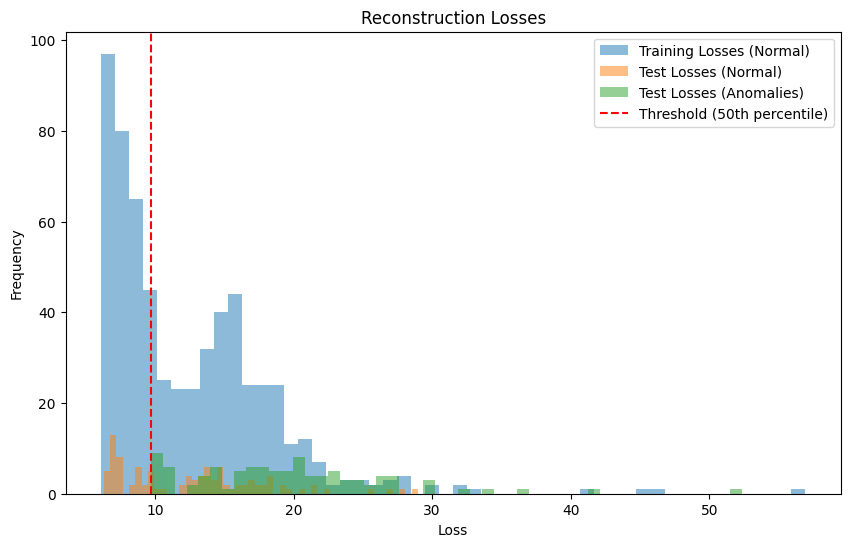

In [625]:
# def plot_reconstruction_loss(percentile, threshold):
plt.figure(figsize=(10, 6))
plt.hist(train_losses, bins=50, alpha=0.5, label='Training Losses (Normal)')
plt.hist(y_scores[np.array(y_true) == 0], bins=50, alpha=0.5, label='Test Losses (Normal)')
plt.hist(y_scores[np.array(y_true) == 1], bins=50, alpha=0.5, label='Test Losses (Anomalies)')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({percentile}th percentile)')
plt.title('Reconstruction Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

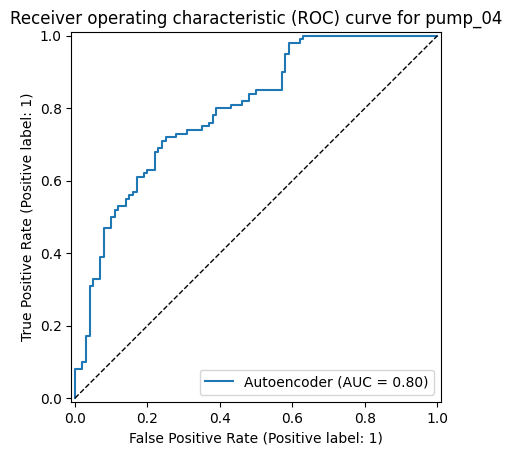

In [626]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, y_scores, name="Autoencoder")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"Receiver operating characteristic (ROC) curve for {MACHINE}");

In [627]:
def evaluation_metrics(y_true, y_pred):

    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    tpr_value = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr_value = fp / (fp + tn)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate (Recall): {tpr_value:.4f}")
    print(f"False Positive Rate: {fpr_value:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")

## 2. One-Class SVM and Isolation Forest

From the trained AutoEncoder, use the bottleneck features to train a (1) One-Class SVM and (2) Isolation Forest, and report the accuracy, F1-score and auc score of each method.

In [628]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score


In [629]:
# Get normal training features
y_pred_train, extracted_features_train = test_loop(data_train, model, loss_fn)

### One-Class SVM

In [630]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using training data
# TODO : Report essential evaluation metrics
# ===================================
svm = OneClassSVM()
svm.fit(extracted_features_train)
predicted_score = svm.predict(extracted_features_test) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)
# ===================================
roc_auc = metrics.roc_auc_score(y_true, predicted_score)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")


ROC AUC Score on Test Set: 0.5000
Accuracy Score on Test Set: 0.5000
F1 Score on Test Set: 0.5238


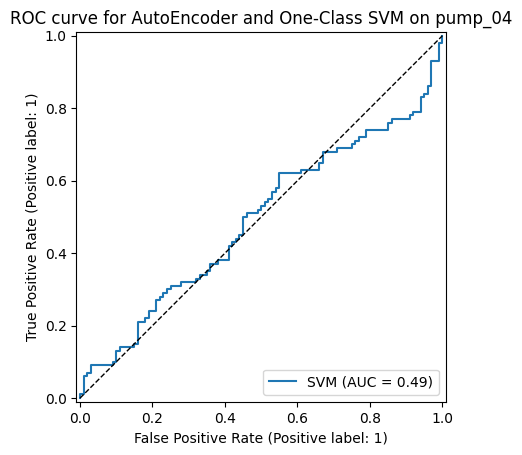

In [631]:
y_test_proba_svm = svm.decision_function(extracted_features_test)
RocCurveDisplay.from_predictions(y_true, y_test_proba_svm, name="SVM")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for AutoEncoder and One-Class SVM on {MACHINE}");

### Isolation Forest

In [632]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using training data
# TODO : Report essential evaluation metrics
# ===================================
isolation_forest = IsolationForest(contamination = 0.5)
isolation_forest.fit(extracted_features_train)
y_test_proba_iso_forest = -isolation_forest.decision_function(extracted_features_test)
predicted_score = isolation_forest.predict(extracted_features_test) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)
# ===================================

roc_auc = metrics.roc_auc_score(y_true, y_test_proba_iso_forest)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")

ROC AUC Score on Test Set: 0.6126
Accuracy Score on Test Set: 0.5550
F1 Score on Test Set: 0.6245


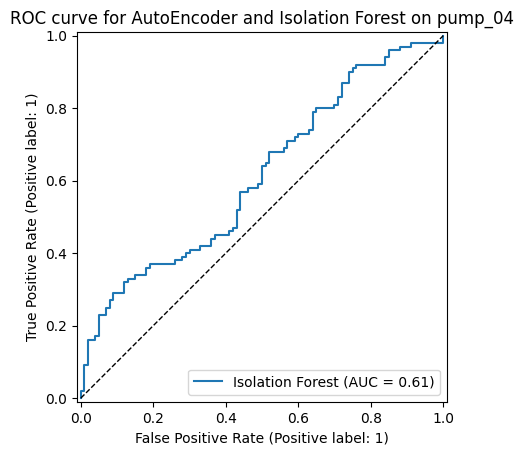

In [633]:
RocCurveDisplay.from_predictions(y_true, y_test_proba_iso_forest, name="Isolation Forest")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for AutoEncoder and Isolation Forest on {MACHINE}");

## **Question 3:** Instead of using AutoEncoder features, apply PCA to project the MEL-spectrogram into a smaller dimensional space, then train (1) a One-Class SVM and (2) an Isolation Forest, and report the AUC scores.


PCA of the spectrograms to reduce the input dimension

In [634]:
# Extract spectrograms of training and testing
flatten_spectogram_train = []
for idx, (x, _) in enumerate(data_train):
    x = x.flatten()
    flatten_spectogram_train.append(x.numpy())
train_spec = np.array(flatten_spectogram_train)

flatten_spectogram_test = []
for idx, (x, _) in enumerate(data_test):
    x = x.flatten()
    flatten_spectogram_test.append(x.numpy())
test_spec = np.array(flatten_spectogram_test)

Apply PCA to fit and transform the training data and transform also the test data

In [635]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)

# TODO : Fit and transform the training data (train_spec)
# TODO : Transform the testing data (test_spec)
# ===================================
train_spec_pca = pca.fit_transform(train_spec)
test_spec_pca = pca.transform(test_spec)
# ===================================

Apply OneClassSVM and IsolationForest on the new PCA features.

In [636]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
svm_pca = OneClassSVM()
svm_pca.fit(train_spec_pca)
predicted_score_proba = svm_pca.score_samples(test_spec_pca)
predicted_score = svm_pca.predict(test_spec_pca) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

print('PCA, then One-Class SVM Results:')

# if using these thresholded results for the ROC curve, then AUC will be worse!! instead use y_test_proba_svm_pca
roc_auc = metrics.roc_auc_score(y_true, -predicted_score_proba)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")
# ===================================


PCA, then One-Class SVM Results:
ROC AUC Score on Test Set: 0.8542
Accuracy Score on Test Set: 0.7450
F1 Score on Test Set: 0.7901


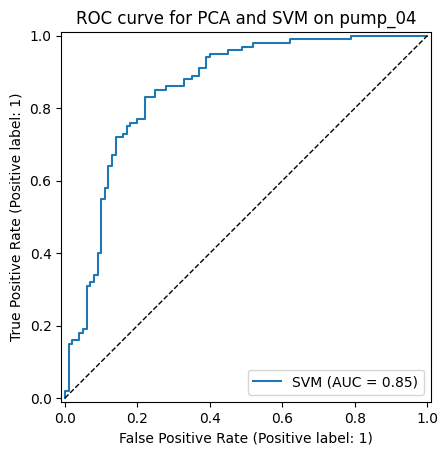

In [637]:
y_test_proba_svm_pca = -svm_pca.decision_function(test_spec_pca)
RocCurveDisplay.from_predictions(y_true, y_test_proba_svm_pca, name="SVM")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for PCA and SVM on {MACHINE}");

In [638]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
isolation_forest_pca = IsolationForest(contamination = 0.5)
isolation_forest_pca.fit(train_spec_pca)
predicted_score_proba = isolation_forest_pca.score_samples(test_spec_pca)
predicted_score = isolation_forest_pca.predict(test_spec_pca) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

print('Isolation Forest Results')
roc_auc = metrics.roc_auc_score(y_true, -predicted_score_proba)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")
# ===================================



Isolation Forest Results
ROC AUC Score on Test Set: 0.9082
Accuracy Score on Test Set: 0.7950
F1 Score on Test Set: 0.8145


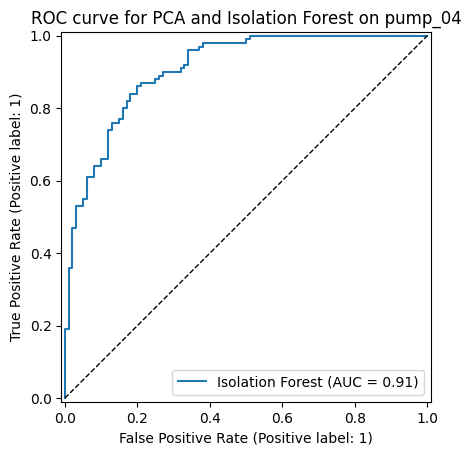

In [639]:
y_test_proba_svm_if = -isolation_forest_pca.decision_function(test_spec_pca)
RocCurveDisplay.from_predictions(y_true, y_test_proba_svm_if, name="Isolation Forest")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for PCA and Isolation Forest on {MACHINE}");

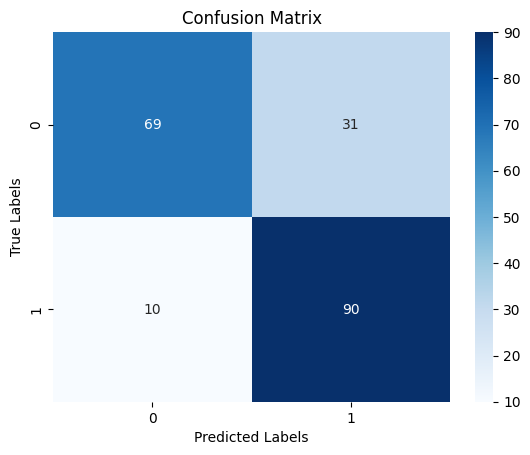

Accuracy: 0.7950
True Positive Rate (Recall): 0.9000
False Positive Rate: 0.3100
Precision: 0.7438
F1-Score: 0.8145


In [640]:
evaluation_metrics(y_true, predicted_score)

## **Question 4:** Determine an appropriate threshold for distinguishing anomalies based on the given results, and compute the following metrics: Accuracy, True Positive Rate (TPR), False Positive Rate (FPR), and F1-score.

From Moodle: "For question 4, you only need define a threshold for the Autoencoder, and compute these metrics based on this threshold. As for IsolationForest and One-Class SVM, you don't have to manully define a threshold to compute these metrics."


- y_pred_train are the decision values that we want to threshold
- y_train are the true y labels

In [641]:
def evaluate_model(model, bottleneck_features, true_labels):
    roc_auc = metrics.roc_auc_score(y_true, y_scores)
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Compute ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)

    # Compute the Youden's J statistic
    J = tpr - fpr
    idx = np.argmax(J)
    optimal_threshold = thresholds[idx]
    print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

    # Classify samples based on the optimal threshold
    y_pred = (y_scores >= optimal_threshold).astype(int)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    tpr_value = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr_value = fp / (fp + tn)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate (Recall): {tpr_value:.4f}")
    print(f"False Positive Rate: {fpr_value:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return accuracy, f1, roc_auc

In [642]:
def plot_thresholds():
    plt.plot(thresholds, J, label="J Statistic")
    plt.scatter(optimal_threshold, J[idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.4f}')
    plt.title("J Statistic vs. Thresholds")
    plt.xlabel('Threshold')
    plt.ylabel("J Statistic")
    plt.legend()
    plt.gca().invert_xaxis() 
    plt.tight_layout()
    plt.show()

In [643]:
evaluate_model(clf, extracted_features_train, y_true)

ROC AUC Score: 0.7970
Optimal Threshold (Youden's J): 16.2342
Accuracy: 0.7350
True Positive Rate (Recall): 0.7100
False Positive Rate: 0.2400
Precision: 0.7474
F1-Score: 0.7282


(0.735, np.float64(0.7282051282051282), np.float64(0.797))

## **Bonus Question:** Modify the AutoEncoder architecture to a 2D AutoEncoder using convolutional layers instead of fully connected layers, and analyze its performance.

- size of data: 32, 1, 313, 64
- 64 n_mels

In [668]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, 32, 160, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (32, 64, 80, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: (32, 128, 40, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # Output: (32, 256, 20, 4)
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)), # Output: (32, 128, 40, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)),  # Output: (32, 64, 80, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)),   # Output: (32, 32, 160, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)),    # Output: (32, 1, 320, 64)
            nn.Sigmoid()  # Use Sigmoid for reconstruction values
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstruction_vals = self.decoder(encoded)
        return reconstruction_vals

# Example usage
model = ConvAutoencoder()
input_tensor = torch.randn(32, 1, 320, 64)  # Batch size of 32, 1 channel, 320 height, 64 width
output_tensor = model(input_tensor)

# Output shapes
print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)  # Should match input shape


Input shape: torch.Size([32, 1, 320, 64])
Output shape: torch.Size([32, 1, 305, 49])


In [669]:

# Sample input tensor
input_tensor = torch.randn(32, 1, 313, 64)  # Example shape: (batch_size, channels, height, width)

# Create a padding layer
pad = nn.ZeroPad2d((0, 0, 4, 3))  # (left, right, top, bottom)

# Pad the tensor
padded_tensor = pad(input_tensor)
print("Padded tensor shape:", padded_tensor.shape)

# model = ConvolutionalAutoencoder()
# input_tensor = torch.randn(32, 1, 313, 64)  # Batch size of 32, 1 channel, 313 height, 64 width
# input_tensor = pad(input_tensor)
# output_tensor = model(input_tensor)

# print("Input shape:", input_tensor.shape)
# print("Output shape:", output_tensor.shape)  # Should match input shape

# Example usage
model = ConvAutoencoder()
input_tensor = torch.randn(32, 1, 313, 64)  # Batch size of 32, 1 channel, 313 height, 64 width
input_tensor = pad(input_tensor)
output_tensor = model(input_tensor)

# Output shapes
print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)  # Should match input shape


Padded tensor shape: torch.Size([32, 1, 320, 64])
Input shape: torch.Size([32, 1, 320, 64])
Output shape: torch.Size([32, 1, 305, 49])


In [683]:
class ConvolutionalAutoencoder(nn.Module):

    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
      
        self.encoder = nn.Sequential( # [32, 1, 313, 64]
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (8, 78, 16)
        )
        
        # TODO : write a symetrical neural network to the encoder to reconstuct the input
        # ===================================
        # IMPLEMENT YOUR CODE HERE

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=2, 
                               stride=2, 
                               padding=0, 
                               output_padding=(1,0)), # [32, 1, 313, 64])
        )
        
        # ===================================

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction,feature

In [684]:
model2 = ConvolutionalAutoencoder()

In [688]:
#Create a class autoencoder CNN
class CNNAutoencoder(nn.Module):

    def __init__(self, input_channels=1):
        super(CNNAutoencoder, self).__init__()
        # create CNN encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, padding= 1),
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, padding=1),
            )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),  # Adjust the mode and align_corners
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=3),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),  # Adjust the mode and align_corners
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=8, out_channels=input_channels, kernel_size=3)
        )
        
    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        diffinSize = len(reconstruction[0][0])-len(x[0][0])
        reconstruction = reconstruction[0][0][diffinSize//2:-diffinSize//2] #With the upsample we need to rescale the output the corners are not well defined
        return reconstruction, feature
    
model3 = CNNAutoencoder()

In [710]:
def train_loop2(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = dataloader.batch_size
    loss_running = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        x = x.view(num_batches, 1, -1)

        optimizer.zero_grad()

        x_pred,features = model(x)

        #TODO: write the loss function and compute the gradient and update the model parameters
        loss = loss_fn(x_pred, x)

        #to the backpropagation with the loss
        loss.backward()
        optimizer.step()

        # Backpropagation
        loss_running += loss.item()

    print(f"loss: {loss_running/len(dataloader):>7f}")

def test_loop2(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = np.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x = x.view(1,1,-1)
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    return test_losses, np.array(store_feature)

In [696]:
#Get normal training features
def getNewModel(melsp_params, dataToTrain, classEncoder=DenseAutoencoder, batch_size = 32, epochs = 5):
    input_dim = int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
    print(input_dim)

    if(classEncoder == DenseAutoencoder):
        model = DenseAutoencoder(input_dim)
    else:
        model = CNNAutoencoder()
    # PyTorch data loaders allow to iterate batch-wise over a dataset
    train_loader = DataLoader(dataToTrain, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Stochastic gradient descent optimizer
    optimizer = torch.optim.Adam(model.parameters())
    # Mean Squared Error (MSE) loss function to be minimized
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loop2(train_loader, model, loss_fn, optimizer, print_every=1)

    return model


In [697]:
CNNAutoEncoderModel = getNewModel(melsp_params, data_train, CNNAutoencoder)

20032
Epoch 1
-------------------------------


/Users/sopheabonnne/anaconda3/envs/civil-426/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 1, 20032])) that is different to the input size (torch.Size([20032])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


loss: 529.429494
Epoch 2
-------------------------------


100%|██████████| 18/18 [00:18<00:00,  1.05s/it]


loss: 317.997124
Epoch 3
-------------------------------


100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


loss: 113.952916
Epoch 4
-------------------------------


100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


loss: 42.523646
Epoch 5
-------------------------------


100%|██████████| 18/18 [00:16<00:00,  1.09it/s]

loss: 41.432910


In [707]:
print(len(data_train), len(data_test))
data_train[0][0].shape


602 200


torch.Size([1, 313, 64])

In [712]:
y_pred_train_CNN,extracted_features_train_CNN = test_loop2(data_train, CNNAutoEncoderModel, loss_fn)
y_pred_test_CNN,extracted_features_test_CNN = test_loop2(data_test, CNNAutoEncoderModel, loss_fn)

ROC AUC Score on Test Set: 0.4551


In [ ]:
y_true = data_test.labels  # Actual labels (0: normal, 1: anomaly)

auc = metrics.roc_auc_score(y_true, y_pred_test_CNN)
print(f"ROC AUC Score on Test Set: {auc:.4f}")

In [718]:
svm = OneClassSVM()

extracted_features_train_CNN = extracted_features_train_CNN.reshape(extracted_features_train_CNN.shape[0], -1)
extracted_features_test_CNN = extracted_features_test_CNN.reshape(extracted_features_test_CNN.shape[0], -1)

svm.fit(extracted_features_train_CNN)
decision_score = -svm.decision_function(extracted_features_test_CNN) # for ROC curve and AUC
predicted_score = svm.predict(extracted_features_test_CNN) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

roc_auc = metrics.roc_auc_score(y_true, decision_score)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")



ROC AUC Score on Test Set: 0.5342
Accuracy Score on Test Set: 0.4900
F1 Score on Test Set: 0.5278


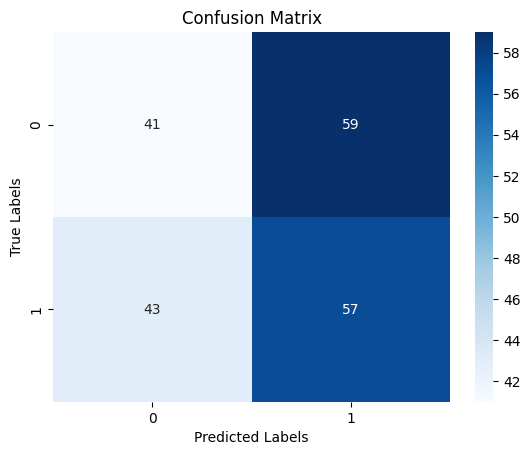

Accuracy: 0.4900
True Positive Rate (Recall): 0.5700
False Positive Rate: 0.5900
Precision: 0.4914
F1-Score: 0.5278


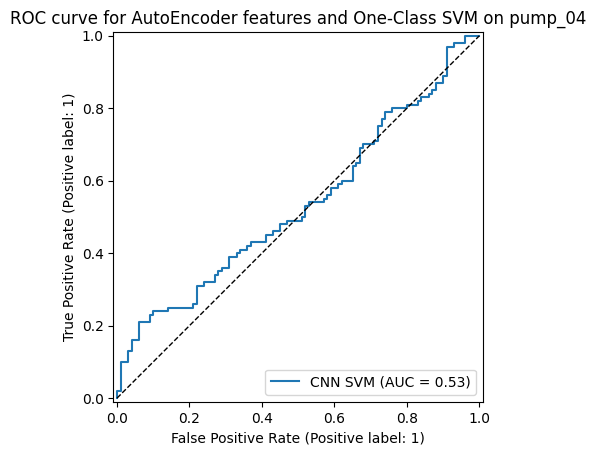

In [720]:
evaluation_metrics(y_true, predicted_score)

metrics.RocCurveDisplay.from_predictions(y_true, decision_score, name="CNN SVM")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for AutoEncoder features and One-Class SVM on {MACHINE}");